In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Standard ML Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Deep learning utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Torch data manipulation
import torchvision
from torchvision import transforms
import albumentations as A

# Metrics
import torchmetrics as tm

# GeoTIFF image
import rasterio as rio
from rasterio.plot import show

In [2]:
# Set device variable
DEVICE = 'cpu' if torch.cuda.is_available else 'cpu'

# Random control
RANDOM_SEED = 42

# Main path
MAIN_PATH = 'C://Users//vishal-sharma//Downloads//archive (2)//AMAZON//AMAZON'

In [3]:
def prepare_path_lists(main_path: str,
                      data_name: str):

    image_list = []
    mask_list = []
    mask_paths = []
    
    # List of possible mask dirs
    for option in ['label', 'mask', 'masks']:
        mask_paths.append(os.path.join(data_name, option))
    
    # Image dir
    image_path = os.path.join(data_name, 'image')
    
    # Loop throught all files to get proper lists
    for root, dirs, files in os.walk(main_path):
        for file in files:
            full_path = os.path.join(root, file)
            if image_path in full_path and full_path.endswith('.tif'):
                image_list.append(full_path)
            elif any(mask in full_path for mask in mask_paths) and full_path.endswith('.tif'):
                mask_list.append(full_path)
                
    return image_list, mask_list

In [4]:
# Training data
training_image_list, training_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Training')

# Test data
test_image_list, test_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Test')

# Validation data
val_image_list, val_mask_list = prepare_path_lists(main_path=MAIN_PATH, data_name='Validation')

In [5]:
train_df = pd.DataFrame(list(zip(training_image_list, training_mask_list)), 
                        columns=['image_path', 'mask_path'])

test_df = pd.DataFrame(list(zip(test_image_list, test_mask_list)), 
                        columns=['image_path', 'mask_path'])

val_df = pd.DataFrame(list(zip(val_image_list, val_mask_list)), 
                        columns=['image_path', 'mask_path'])

print(f'Training data contains: {len(train_df)} files')
print(f'Test data contains: {len(test_df)} files')
print(f'Validation data contains: {len(val_df)} files')

Training data contains: 499 files
Test data contains: 20 files
Validation data contains: 100 files


In [6]:
def calculate_tiff_statistics(df: pd.DataFrame, 
                              band_config: list = None):
    """
    Tiff images statistics used for normalization - MEAN and STD
    """
    
    image_paths = df['image_path']
    total_mean = 0
    total_std = 0
    
    for path in image_paths:
        if band_config is not None:
            img = rio.open(path).read(band_config)
        else:
            img = rio.open(path).read()
        total_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
        total_std += img.reshape((img.shape[0], -1)).std(axis=1)
        
    average_mean = total_mean / len(image_paths)
    average_std = total_std / len(image_paths)
    
    return np.round(average_mean, 1), np.round(average_std, 1)

def get_training_transformation():
    train_transform = [A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                      ]
    return A.Compose(train_transform, 
                     additional_targets={'rgb_image': 'image'}, 
                     is_check_shapes=False)

def normalize_image():
    normalize = [
        transforms.Normalize(mean=mean, std=std)
    ]
    return transforms.Compose(normalize)

def normalize_rgb(x: np.array):
    """
    Normalize a list of sample image data in the range of 0 to 1
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

def visualize_batch(batch: tuple):
    """
    Visualize batch from DataLoader - Original RGB image and Ground truth mask
    """
    images, masks, rgb_images = batch
    
    for index in range(0, len(images)):
        plt.figure(figsize=(18,10))
        mask = masks[index]
        rgb_image = rgb_images[index]
        rgb_image = rgb_image.numpy()
        plt.subplot(1, 2, 1)
        plt.imshow(mask)
        plt.subplot(1, 2, 2)
        show(normalize_rgb(rgb_image))
    plt.show()
    
def plot_statistics(**statistic_lists):
    """
    Visualize provided statistics in a row with correlated name.
    Provide the argument in keyword args format: statistic_name = List[statistics]
    For example: Loss_statistic = [train_loss, test_loss]
    """    
    for index, (name, statistic_list) in enumerate(statistic_lists.items()):
        plt.figure(figsize=(12,8))
        label_name = name.split(' ')[0]
        plt.plot(statistic_list[0], label=f'Training {label_name}')
        plt.plot(statistic_list[1], label=f'Test {label_name}')
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.legend() 

In [7]:
class ForestSegmentationDataset(Dataset):
    def __init__(self,
                df: pd.DataFrame,
                band_config: list = None,
                transform: A.Compose = None,
                normalize: transforms.Compose = None):
        self.df = df
        self.band_config = band_config
        self.transform = transform
        self.normalize = normalize
    
    def __len__(self):
        return len(self.df)
    
    def __str__(self):
        return f'<ForestSegmentationDataset> with {len(self.df)} data'
    
    def __getitem__(self, index):
        with rio.open(self.df['image_path'].iloc[index]) as src:
            if self.band_config is not None:
                image = src.read(self.band_config, out_dtype='float32')
            else:
                image = src.read(out_dtype='float32')
            rgb_image = src.read([1,2,3], out_dtype='float32')
        
        with rio.open(self.df['mask_path'].iloc[index]) as src:
            mask = src.read(out_dtype='float32')
            mask = np.squeeze(mask)
        
        if self.transform:
            random.seed(RANDOM_SEED)
            transformed = self.transform(image=image, 
                                         mask=mask, 
                                         rgb_image=rgb_image)
            image = transformed['image']
            mask = transformed['mask']
            rgb_image = transformed['rgb_image']
        
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        
        if self.normalize:
            image = self.normalize(image)
        
        return image, mask, rgb_image

In [8]:
mean, std = calculate_tiff_statistics(df=train_df)

print(f'Training dataset MEAN statistic list: {mean}')
print(f'Training dataset STD statistic list: {std}')

Training dataset MEAN statistic list: [ 622.6  683.1  436.7 2952. ]
Training dataset STD statistic list: [380.9 276.5 246.8 554. ]


In [9]:
train_dataset = ForestSegmentationDataset(df=train_df,
                                         #transform=get_training_transformation(),
                                         normalize=normalize_image())

test_dataset = ForestSegmentationDataset(df=test_df,
                                         normalize=normalize_image())

In [10]:
train_dataloader = DataLoader(train_dataset,
                             batch_size=6,
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=6,
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

In [11]:
batch = next(iter(train_dataloader))
images, masks, rgb_images = batch
print(f'Batch images shape: {images.shape}')
print(f'Batch masks shape: {masks.shape}')
print(f'Batch rgb_images shape: {rgb_images.shape}')

Batch images shape: torch.Size([6, 4, 512, 512])
Batch masks shape: torch.Size([6, 512, 512])
Batch rgb_images shape: torch.Size([6, 3, 512, 512])


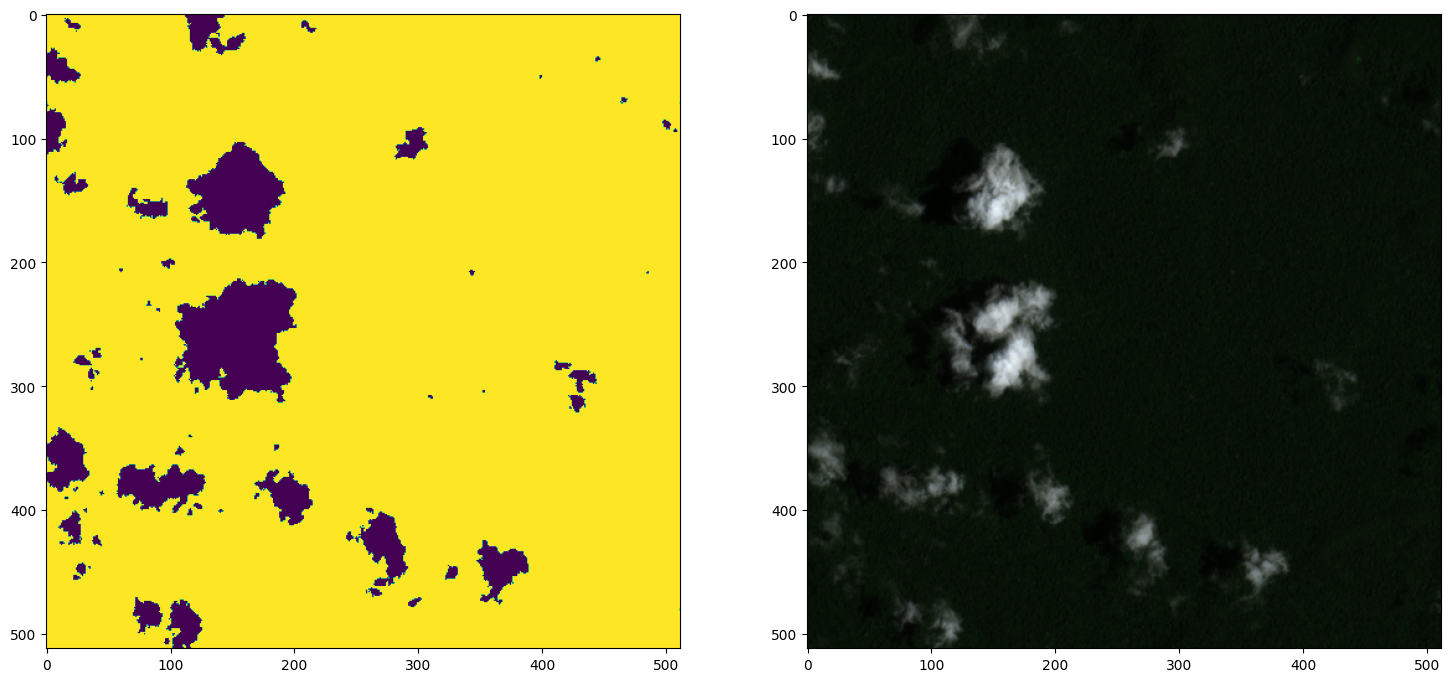

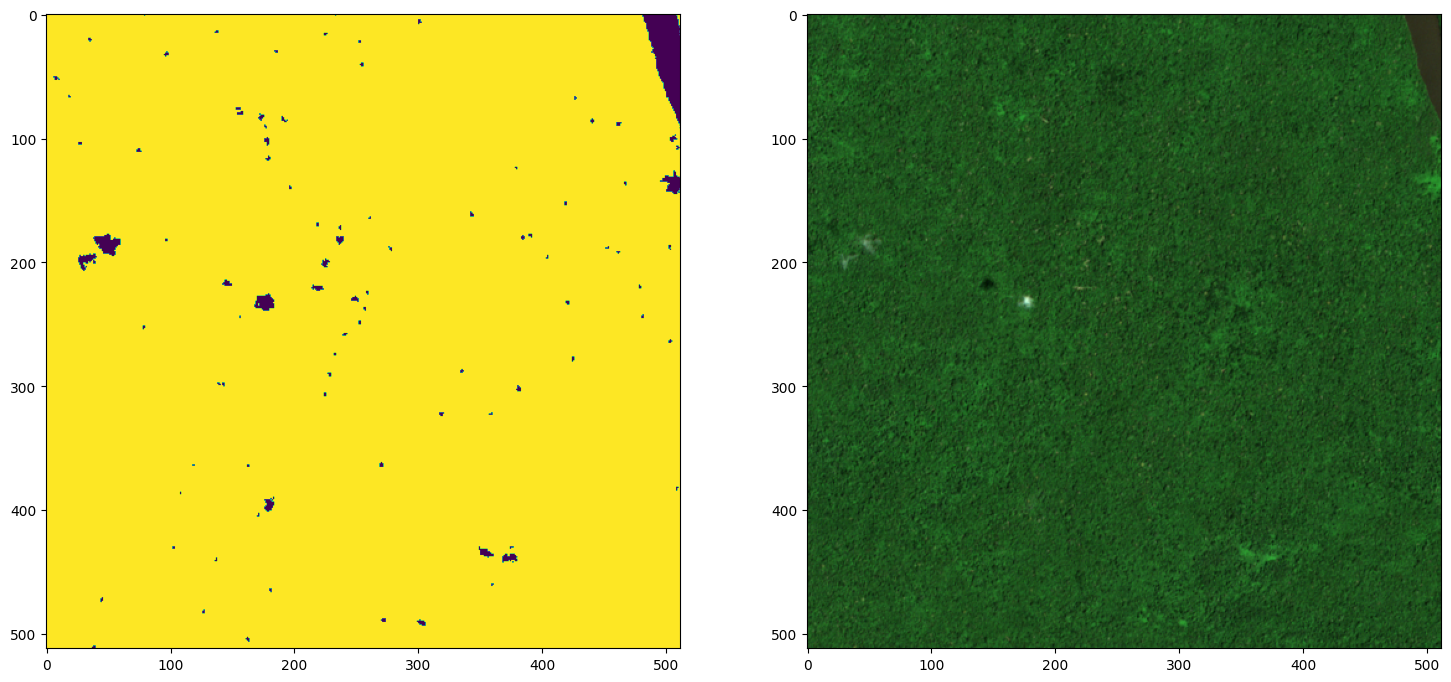

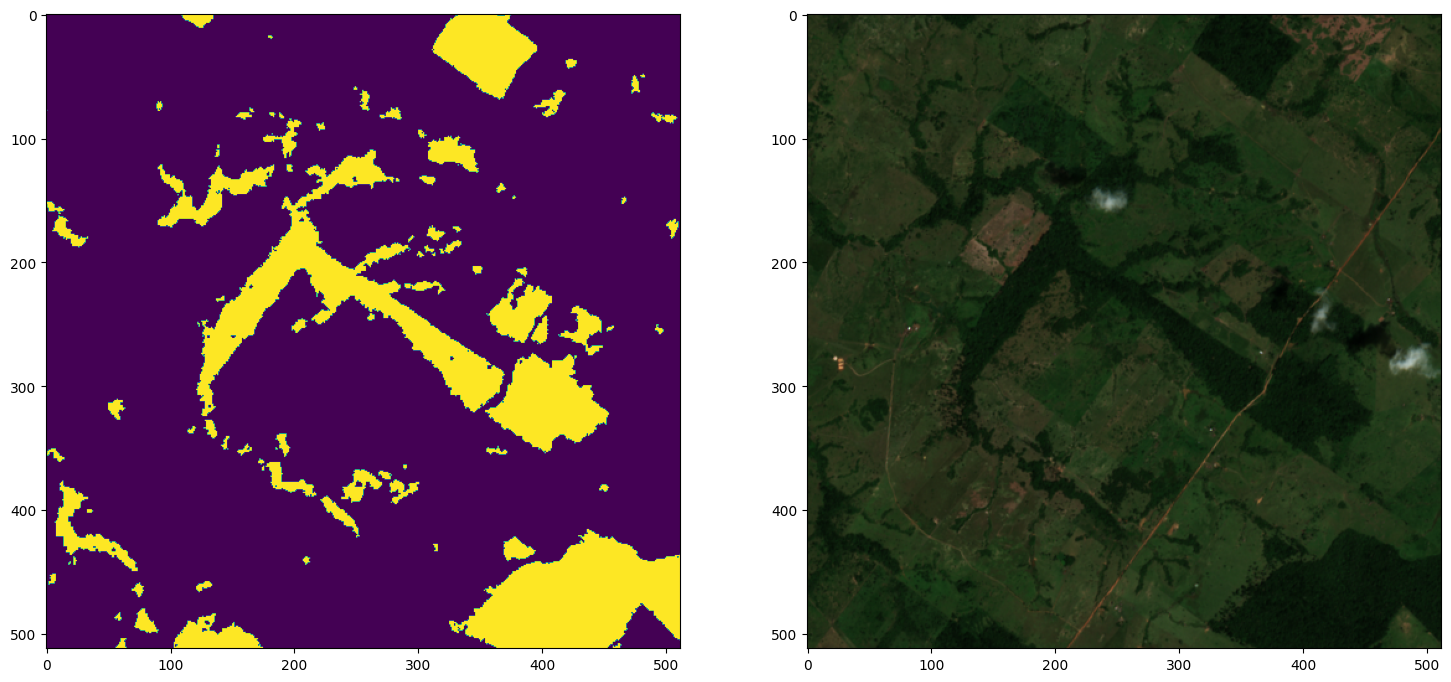

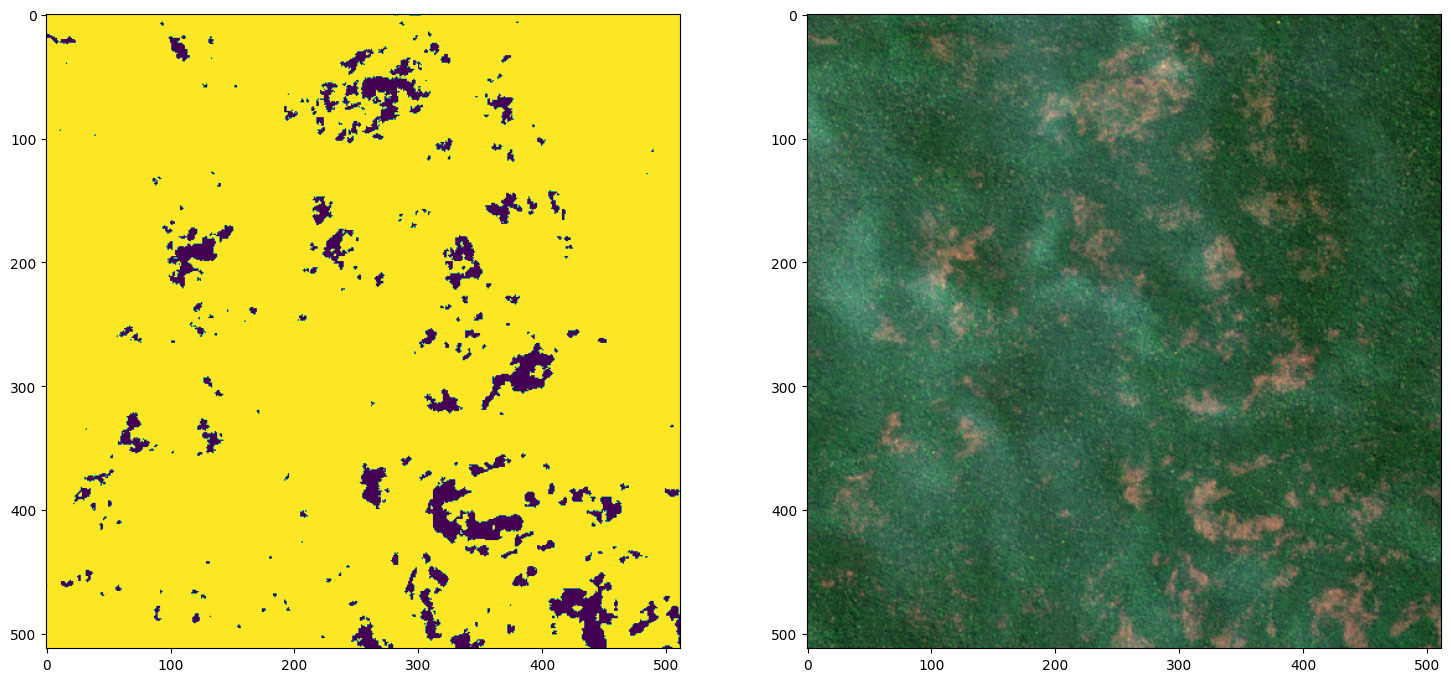

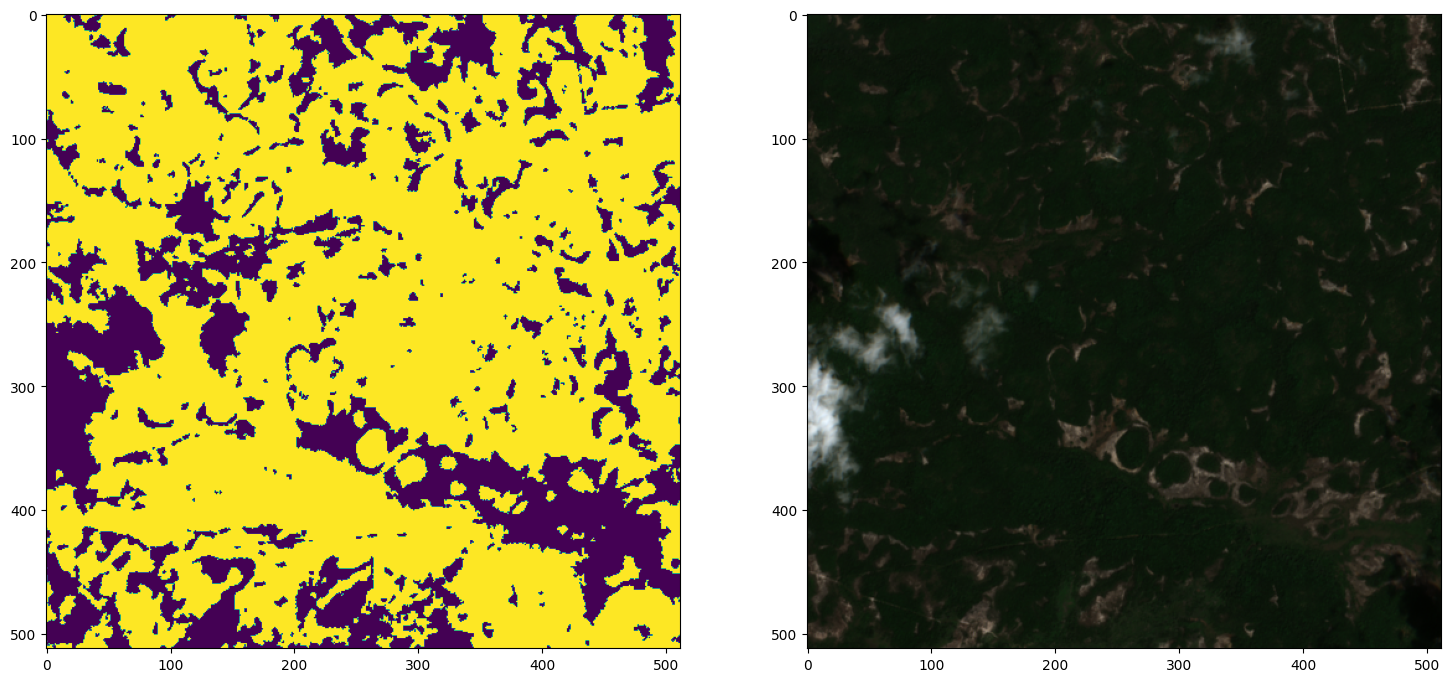

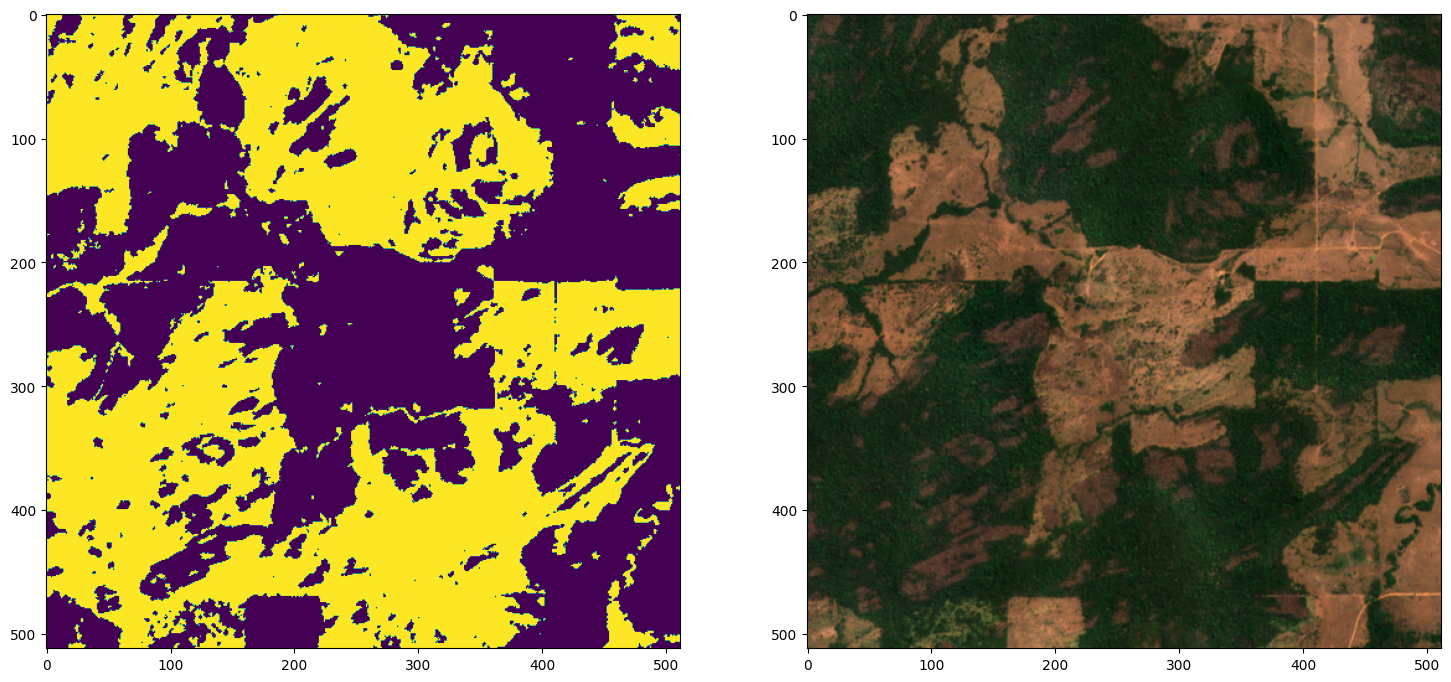

In [12]:
visualize_batch(batch=batch)

In [15]:
def double_conv(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(input_channels, output_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
    )

class ForestSegmentationWithResNet(nn.Module):
    def __init__(self, resnet_encoder, decoder_channel, bottom_channels, class_number):
        super().__init__()

        # Use the ResNet encoder as the base
        self.resnet_encoder = resnet_encoder
        self.bottom_channels = bottom_channels
        self.class_number = class_number

        # Decoder layers
        self.decoder1up = up_conv(bottom_channels, bottom_channels)
        self.decoder1 = double_conv(512 + bottom_channels, decoder_channel[0])

        self.decoder2up = up_conv(decoder_channel[0], decoder_channel[0])
        self.decoder2 = double_conv(256 + decoder_channel[0], decoder_channel[1])

        self.decoder3up = up_conv(decoder_channel[1], decoder_channel[1])
        self.decoder3 = double_conv(128 + decoder_channel[1], decoder_channel[2])

        self.decoder4up = up_conv(decoder_channel[2], decoder_channel[2])
        self.decoder4 = double_conv(64 + decoder_channel[2], decoder_channel[3])

        self.classifier = nn.Conv2d(decoder_channel[3], class_number, kernel_size=1)

    def forward(self, x):
        # Encoder
        encoder_features = self.resnet_encoder(x)

        # Bottleneck
        x = self.bottleneck(encoder_features[-1])

        # Decoder
        x = self.decoder1up(x)
        x = torch.cat([x, encoder_features[-1]], dim=1)
        x = self.decoder1(x)

        x = self.decoder2up(x)
        x = torch.cat([x, encoder_features[2]], dim=1)
        x = self.decoder2(x)

        x = self.decoder3up(x)
        x = torch.cat([x, encoder_features[1]], dim=1)
        x = self.decoder3(x)

        x = self.decoder4up(x)
        x = torch.cat([x, encoder_features[0]], dim=1)
        x = self.decoder4(x)

        # Classifier head
        x = self.classifier(x)

        return x
# Load a pre-trained ResNet model
resnet_model = models.resnet34(pretrained=True)

# Modify the number of input channels of the first convolution layer in the ResNet model to match your input_channels
resnet_model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Extract the encoder part of the ResNet model
resnet_encoder = nn.Sequential(*list(resnet_model.children())[:-2])

# Create the segmentation model with ResNet encoder
model_with_resnet = ForestSegmentationWithResNet(resnet_encoder, decoder_channel=[128, 64, 32, 16], bottom_channels=256, class_number=2)


In [16]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Use torch.sigmoid instead of F.sigmoid

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)

        return 1 - IoU

TypeError: ForestSegmentationWithResNet.__init__() got an unexpected keyword argument 'encoder_channel'